In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pmdarima import auto_arima
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import shapiro
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import kpss, adfuller

In [2]:
plt.rcParams["font.family"] = "Times New Roman"

In [3]:
plt.rcParams['font.size'] = 10

In [4]:
df = pd.read_excel('C:/JupyterLab/AI_prediction/data/US_ml_models.xlsx')

In [5]:
df

,year,ml_models
0,2003,5
1,2004,1
2,2005,3
3,2006,4
4,2007,2
5,2008,4
6,2009,8
7,2010,5
8,2011,8
9,2012,5


In [6]:
df = df.set_index('year', drop=False)

([<matplotlib.axis.XTick at 0x1f7fe97e660>,
 [Text(2004, 0, '2004'),
  Text(2007, 0, '2007'),
  Text(2010, 0, '2010'),
  Text(2013, 0, '2013'),
  Text(2016, 0, '2016'),
  Text(2019, 0, '2019'),
  Text(2022, 0, '2022')])

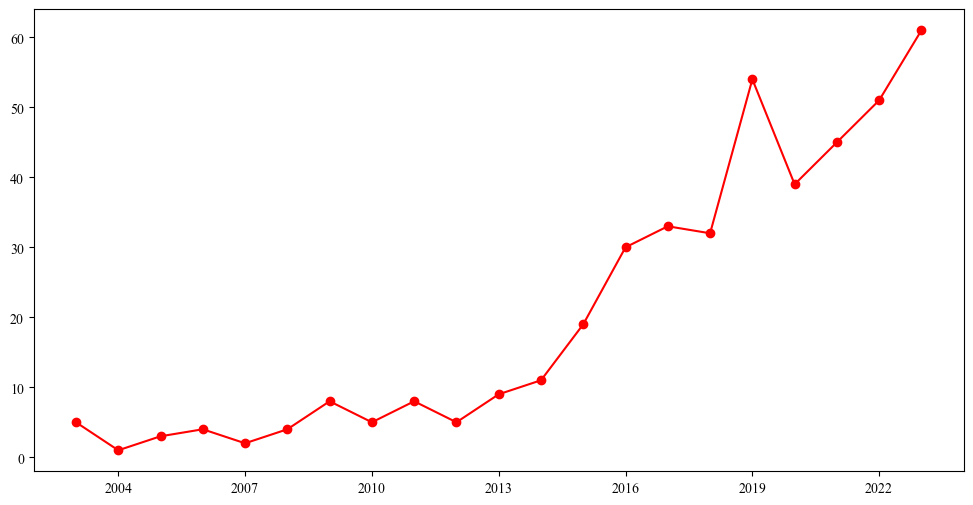

In [7]:
xticks_labels = df.index.tolist()
xticks_filtered = [year for year in xticks_labels if year % 3 == 0]

plt.figure(figsize=(12, 6))
plt.plot(df['ml_models'], marker='o', color='red', label='ml_models')
plt.xticks(xticks_filtered)

There is a positive trend in the number of significant machinle leraning models. The values quickly rise after 2014. In the next step type of trend visible in the data was examined.

### Trend type verification

In [8]:
y = df["ml_models"]
t = df["year"]

X_lin = sm.add_constant(t)
model_lin = sm.OLS(y, X_lin).fit()

X_quad = sm.add_constant(np.column_stack((t, t**2)))
model_quad = sm.OLS(y, X_quad).fit()

# Linear model statistics
p_value_lin = model_lin.pvalues.iloc[1] 
r2_lin = model_lin.rsquared
se_lin = np.sqrt(model_lin.mse_resid)
f_lin = model_lin.fvalue
f_crit_lin = stats.f.ppf(0.95, model_lin.df_model, model_lin.df_resid)

# Quadratic model statistics
p_value_quad = model_quad.pvalues.iloc[1]
r2_quad = model_quad.rsquared
se_quad = np.sqrt(model_quad.mse_resid)
f_quad = model_quad.fvalue
f_crit_quad = stats.f.ppf(0.95, model_quad.df_model, model_quad.df_resid)

# Degrees of freedom 
n = len(df)
k_lin = X_lin.shape[1] 
k_quad = X_quad.shape[1] 

df1_new = n - k_lin - 1
df2_new = n - k_quad - 1

F_user_updated = (se_lin / se_quad) ** 2
F_crit_updated = stats.f.ppf(0.95, df1_new, df2_new)

pd.options.display.float_format = '{:.8f}'.format

results_updated = pd.DataFrame({
    "Statistic": [
        "p-value (t-test for trend coefficient)",
        "R-squared",
        "Standard error of residuals",
        "F-statistic (user definition)",
        "Critical F (alpha=0.05, user definition)"
    ],
    "Linear trend model": [
        p_value_lin, r2_lin, se_lin, F_user_updated, F_crit_updated
    ],
    "Quadratic trend model": [
        p_value_quad, r2_quad, se_quad, F_user_updated, F_crit_updated
    ]
})

results_updated

,Statistic,Linear trend model,Quadratic trend model
0,p-value (t-test for trend coefficient),0.00000001,0.00003182
1,R-squared,0.83507969,0.93878016
2,Standard error of residuals,8.25202807,5.16547496
3,F-statistic (user definition),2.55211871,2.55211871
4,"Critical F (alpha=0.05, user definition)",2.25667097,2.25667097


Based on the p-value for the Student's t-test, the null hypothesis should be rejected, therefore, the parameter for the quadratic trend model was significantly different from zero. The quadratic trend model also achieved a lot higher R-squared statistic and a lower standard error of the residuals. The error ratio was lower than the critical value for Fisher's test, so the decrease in residual variance proved statistically significant.

### Stationarity testing

In [9]:
kpss(df["ml_models"], nlags=4, regression="ct")
df["time"] = df["year"]
df["timesq"] = df["year"]**2
X_trend = sm.add_constant(df[["time", "timesq"]])
model_trend = sm.OLS(df["ml_models"], X_trend).fit()
residuals_trend = model_trend.resid
kpss(residuals_trend, regression="c", nlags=4)

C:\Users\tester\AppData\Local\Temp\ipykernel_13024\1192270414.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(residuals_trend, regression="c", nlags=4)


(np.float64(0.07724283950235769),
 np.float64(0.1),
 4,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

The InterpolationWarning indicates a limitation of the KPSS implementation in statsmodels because the computed test statistic lies outside the range of p values available in the built in lookup table. As a result, the reported p value is only an upper bound rather than an exact probability. In this analysis, p values and critical values were additionally calculated with an external program to improve accuracy. These external calculations showed that for the KPSS test with a linear trend the critical value is slightly larger than the test statistic, while when a quadratic trend is included the opposite occurs and the test statistic slightly exceeds the critical value. This demonstrates that the conclusion depends on the chosen trend specification and that the internal lookup tables may not fully capture extreme test statistic values.

In [10]:
df["year_centered"] = df["year"] - df["year"].min()
df["year_squared"] = df["year_centered"] ** 2

# ADF test for linear trend
adf_result_ct = adfuller(df["ml_models"], regression="ct", autolag="AIC")  
# ADF test for quadratic trend
X_quad = sm.add_constant(df[["year_centered", "year_squared"]])
model_quad = sm.OLS(df["ml_models"], X_quad).fit()
residuals_quad = model_quad.resid
adf_result_quad = adfuller(residuals_quad, regression="c", autolag="AIC")

# ADF results with critical values
test_results_adf = {
    "ADF (linear trend)": {
        "Statistic": adf_result_ct[0],
        "p-value": adf_result_ct[1],
        "Lags": adf_result_ct[2],
        "Critical Values": adf_result_ct[4],
    },
    "ADF (quadratic trend)": {
        "Statistic": adf_result_quad[0],
        "p-value": adf_result_quad[1],
        "Lags": adf_result_quad[2],
        "Critical Values": adf_result_quad[4],
    },
}

test_results_adf


{'ADF (linear trend)': {'Statistic': np.float64(-2.2675055202281547),
  'p-value': np.float64(0.4520000062705981),
  'Lags': 0,
  'Critical Values': {'1%': np.float64(-4.499264375),
   '5%': np.float64(-3.65827175),
   '10%': np.float64(-3.26894)}},
 'ADF (quadratic trend)': {'Statistic': np.float64(-3.395281492127042),
  'p-value': np.float64(0.011120780783777756),
  'Lags': 8,
  'Critical Values': {'1%': np.float64(-4.137829282407408),
   '5%': np.float64(-3.1549724074074077),
   '10%': np.float64(-2.7144769444444443)}}}

The results indicate that the time series is not stationary. Beacause of that, ARIMA models were trained with d parameter bigger or equal to 1. Before model estimation, PACF and ACF charts for differenced time series were drawn to estimate autocorrelations within time series.

### Autocorelation functions

In [11]:
time_series_diff = np.diff(df["ml_models"])

df_diff = pd.DataFrame({"Differenced": time_series_diff})

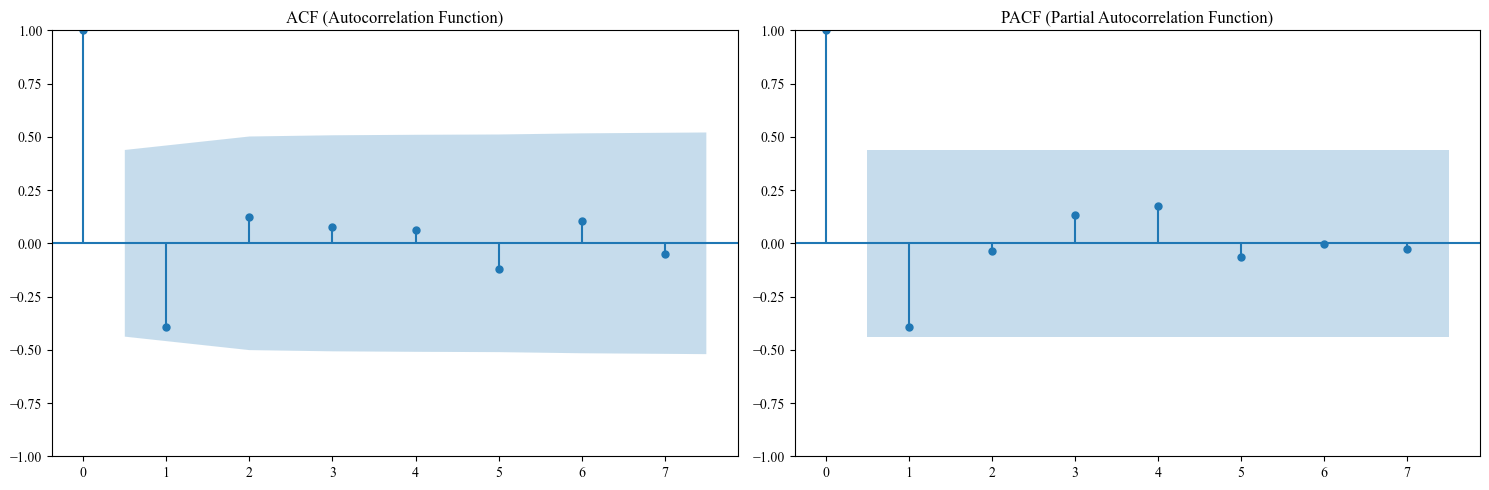

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sm.graphics.tsa.plot_acf(df_diff["Differenced"], lags=7, alpha=0.05, ax=axes[0], title="ACF (Autocorrelation Function)")

sm.graphics.tsa.plot_pacf(df_diff["Differenced"], lags=7, alpha=0.05, ax=axes[1], title="PACF (Partial Autocorrelation Function)")

plt.tight_layout()
plt.show()

Values for the lags are not significant, therefore we do not observe a moving average or autoregressive process in the series

### ARIMA forecast on training dataset

#### Choosing best ARIMA model

In [13]:
df3 = df.set_index('year')

In [14]:
train_size = len(df) - 4  
train, test = df['ml_models'][:train_size], df['ml_models'][train_size:]
train_years = df['year'][:train_size]
test_years = df['year'][train_size:]

Training data excludes last 4 years of the time series, it has about 80% of all observations. 

In [15]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [16]:
train

year
2003     5
2004     1
2005     3
2006     4
2007     2
2008     4
2009     8
2010     5
2011     8
2012     5
2013     9
2014    11
2015    19
2016    30
2017    33
2018    32
2019    54
Name: ml_models, dtype: int64

In [17]:
stepwise_fit = auto_arima(train, trace=True, start_p=0, start_d=1, start_q=0, information_criterion='aic', test='adf',
suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=105.883, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=105.343, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=102.990, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=103.985, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=102.197, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 0.430 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   17
Model:               SARIMAX(0, 2, 2)   Log Likelihood                 -48.099
Date:                Mon, 20 Oct 2025   AIC                            102.197
Time:                        12:32:23   BIC                            104.321
Sample:                             0   HQIC                           102.175
                                 - 17                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2214      0.184     -6.636      0.000      -1.582      -0.861
ma.L2          0.5776      0.141      4.086      0.000       0.301       0.855
sigma2        31.8230     12.230      2.602      0.009       7.853      55.793
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 0.00
Prob(Q):                              0.73   Prob(JB):                         1.00
Heteroskedasticity (H):               9.77   Skew:                            -0.01
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
stepwise_fit = auto_arima(train, trace=True, start_p=0, start_d=1, start_q=0, information_criterion='bic', test='adf',
suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize bic
 ARIMA(0,2,0)(0,0,0)[0]             : BIC=106.591, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : BIC=106.759, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : BIC=104.406, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : BIC=106.109, Time=0.16 sec
 ARIMA(0,2,2)(0,0,0)[0]             : BIC=104.321, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : BIC=inf, Time=0.08 sec
 ARIMA(0,2,3)(0,0,0)[0]             : BIC=inf, Time=0.07 sec
 ARIMA(1,2,3)(0,0,0)[0]             : BIC=inf, Time=0.11 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : BIC=inf, Time=0.09 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 0.572 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   17
Model:               SARIMAX(0, 2, 2)   Log Likelihood                 -48.099
Date:                Mon, 20 Oct 2025   AIC                            102.197
Time:                        12:32:23   BIC                            104.321
Sample:                             0   HQIC                           102.175
                                 - 17                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2214      0.184     -6.636      0.000      -1.582      -0.861
ma.L2          0.5776      0.141      4.086      0.000       0.301       0.855
sigma2        31.8230     12.230      2.602      0.009       7.853      55.793
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 0.00
Prob(Q):                              0.73   Prob(JB):                         1.00
Heteroskedasticity (H):               9.77   Skew:                            -0.01
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA (0,2,2) has the best information criteria values for both tests.

#### ARIMA (0,2,2) on testing dataset forecast

In [19]:
sarima=ARIMA(train,order=(0,2,2))
predicted2=sarima.fit()

In [20]:
print(predicted2.summary())

                               SARIMAX Results                                
Dep. Variable:              ml_models   No. Observations:                   17
Model:                 ARIMA(0, 2, 2)   Log Likelihood                 -48.099
Date:                Mon, 20 Oct 2025   AIC                            102.197
Time:                        12:32:23   BIC                            104.321
Sample:                             0   HQIC                           102.175
                                 - 17                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2214      0.184     -6.636      0.000      -1.582      -0.861
ma.L2          0.5776      0.141      4.086      0.000       0.301       0.855
sigma2        31.8230     12.230      2.602      0.0

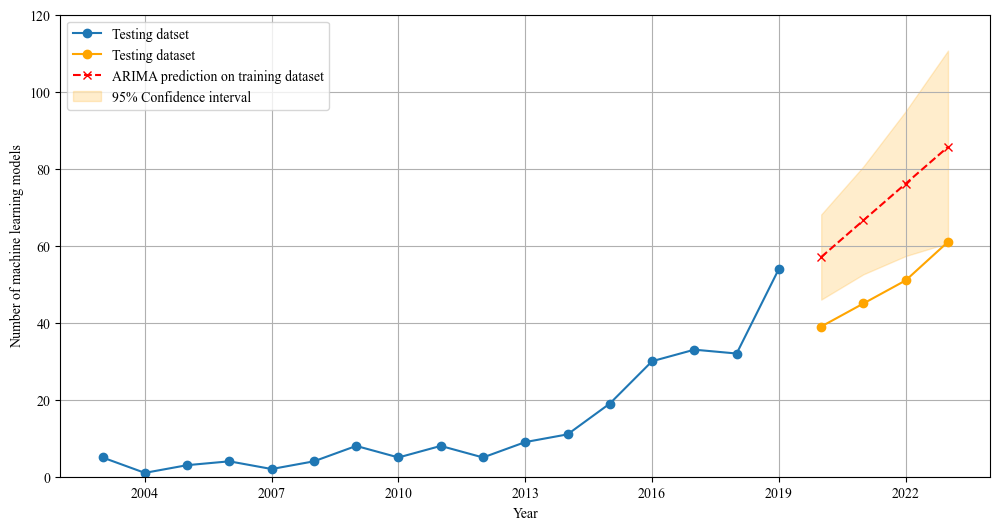

In [21]:
forecast_steps = 4
forecast_result = predicted2.get_forecast(steps=forecast_steps)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

future_years = test_years.values

plt.figure(figsize=(12, 6))
plt.plot(train_years, train, label='Testing datset', marker='o')
plt.plot(test_years, test, label='Testing dataset', color='orange', marker='o')
plt.plot(future_years, forecast_mean, label='ARIMA prediction on training dataset', marker='x', linestyle='--', color='red')
plt.fill_between(future_years, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.2, label='95% Confidence interval')

plt.xlabel('Year')
plt.ylabel('Number of machine learning models')
plt.title('')
plt.legend()
plt.ylim(0, 120) 
plt.xticks(xticks_filtered)
plt.grid(True)
plt.show()

The forecast significantly overestimated the actual values, indicating that the dynamic growth rate of the number of important machine learning models will continue in the coming years.

In [22]:
residuals2 = predicted2.resid

In [23]:
predicted2=sarima.fit().predict();predicted2

year
2003    0.00000000
2004    7.49995910
2005   -2.99927644
2006    0.90828420
2007    3.09050071
2008    2.45048304
2009    3.59154936
2010    7.57118425
2011    7.56439865
2012    9.02763527
2013    7.15315073
2014    8.43817562
2015   10.93860305
2016   18.64107733
2017   31.78147969
2018   41.06520184
2019   42.77521040
Name: predicted_mean, dtype: float64

In [24]:
actual_values = test.values
predicted_values = forecast_mean.values

mse_art = mean_squared_error(actual_values, predicted_values)
rmse_art = np.sqrt(mse_art)
mae_art = mean_absolute_error(actual_values, predicted_values)
mape_art = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
r2_art = r2_score(actual_values, predicted_values)

print(f"MSE: {mse_art:.2f}")
print(f"RMSE: {rmse_art:.2f}")
print(f"MAE: {mae_art:.2f}")
print(f"MAPE: {mape_art:.2f}%")
print(f"R-squared: {r2_art:.2f}")

MSE: 508.14
RMSE: 22.54
MAE: 22.36
MAPE: 46.00%
R-squared: -6.70


In [25]:
shapiro_stat, shapiro_p = shapiro(residuals2)
print(f"Test Shapiro–Wilka: statystyka = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

Test Shapiro–Wilka: statystyka = 0.9786, p-value = 0.9433


In [26]:
arch_test = het_arch(residuals2)
print(f"ARCH test p-value: {arch_test[1]:.4f}")

ARCH test p-value: 0.1752


The ARIMA model's prediction errors are considered very high. The mean absolute percentage error of 46% is unacceptable. The Shapiro-Wilk test assumes the null hypothesis of a normal residual distribution. Based on the p-value from the ARCH test, the variance of the model's residuals is homoscedastic. The test results suggest that the model was correctly selected for the data and that no additional data transformation was necessary.

### ARIMA forecast on full dataset

#### Choosing best ARIMA model

In [27]:
df.info()
df2 = df.set_index('year')

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 2003 to 2023
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   year           21 non-null     int64
 1   ml_models      21 non-null     int64
 2   time           21 non-null     int64
 3   timesq         21 non-null     int64
 4   year_centered  21 non-null     int64
 5   year_squared   21 non-null     int64
dtypes: int64(6)
memory usage: 1.1 KB


In [28]:
warnings.filterwarnings('ignore')

In [29]:
stepwise_fit = auto_arima(df2['ml_models'], trace=True, start_p=0, start_d=0, start_q=0, test='adf', information_criterion='aic',
suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=150.235, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=140.532, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=136.365, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=134.573, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=135.819, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=135.944, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=134.179, Time=0.03 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=135.780, Time=0.04 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 0.413 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   21
Model:               SARIMAX(0, 2, 2)   Log Likelihood                 -64.089
Date:                Mon, 20 Oct 2025   AIC                            134.179
Time:                        12:32:24   BIC                            137.012
Sample:                             0   HQIC                           134.658
                                 - 21                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2831      0.227     -5.650      0.000      -1.728      -0.838
ma.L2          0.4560      0.235      1.938      0.053      -0.005       0.917
sigma2        44.9231     14.882      3.019      0.003      15.756      74.091
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):                 1.14
Prob(Q):                              0.46   Prob(JB):                         0.57
Heteroskedasticity (H):              11.96   Skew:                            -0.29
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
stepwise_fit = auto_arima(df2['ml_models'], trace=True, start_p=0, start_d=0, start_q=0, test='adf', information_criterion='bic',
suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize bic
 ARIMA(0,2,0)(0,0,0)[0]             : BIC=151.179, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : BIC=142.421, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : BIC=138.254, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : BIC=137.406, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : BIC=139.596, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : BIC=139.722, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0]             : BIC=137.012, Time=0.03 sec
 ARIMA(0,2,3)(0,0,0)[0]             : BIC=139.558, Time=0.04 sec
 ARIMA(1,2,3)(0,0,0)[0]             : BIC=inf, Time=0.13 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : BIC=inf, Time=0.09 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 0.444 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   21
Model:               SARIMAX(0, 2, 2)   Log Likelihood                 -64.089
Date:                Mon, 20 Oct 2025   AIC                            134.179
Time:                        12:32:24   BIC                            137.012
Sample:                             0   HQIC                           134.658
                                 - 21                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2831      0.227     -5.650      0.000      -1.728      -0.838
ma.L2          0.4560      0.235      1.938      0.053      -0.005       0.917
sigma2        44.9231     14.882      3.019      0.003      15.756      74.091
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):                 1.14
Prob(Q):                              0.46   Prob(JB):                         0.57
Heteroskedasticity (H):              11.96   Skew:                            -0.29
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Best parameters for ARIMA model for both criterion are (0,2,0)

In [31]:
stepwise_fit

ARIMA(order=(0, 2, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [32]:
sarima=ARIMA(df2['ml_models'],order=(0,2,2))
predicted=sarima.fit()

In [33]:
data = {'Date': [2024, 2025, 2026, 2027]}

future_dates = pd.DataFrame(data)

print(future_dates)

   Date
0  2024
1  2025
2  2026
3  2027


In [34]:
future_dates = [2024, 2025, 2026, 2027]

#### ARIMA (0,2,2) forecast

In [35]:
residuals = predicted.resid

In [36]:
forecast_steps = 4
forecast = predicted.get_forecast(steps=forecast_steps)

forecast_index = range(df2.index[-1] + 1, df2.index[-1] + 1 + forecast_steps)

forecast_values = forecast.predicted_mean

confidence_intervals = forecast.conf_int(alpha=0.25)
lower_bounds = confidence_intervals.iloc[:, 0] 
upper_bounds = confidence_intervals.iloc[:, 1]

df_forecast = pd.DataFrame({
    'Prediction': forecast_values.values,  
    'Lower Bound': lower_bounds.values,
    'Upper Bound': upper_bounds.values
}, index=forecast_index)

print(df_forecast)

      Prediction  Lower Bound  Upper Bound
2024 62.79669036  55.08650530  70.50687542
2025 67.49289558  58.00623648  76.97955468
2026 72.18910079  60.48181756  83.89638403
2027 76.88530601  62.59570416  91.17490786


In [37]:
confidence_intervals

,lower ml_models,upper ml_models
21,55.08650530,70.50687542
22,58.00623648,76.97955468
23,60.48181756,83.89638403
24,62.59570416,91.17490786


In [38]:
forecast_index

range(2024, 2028)

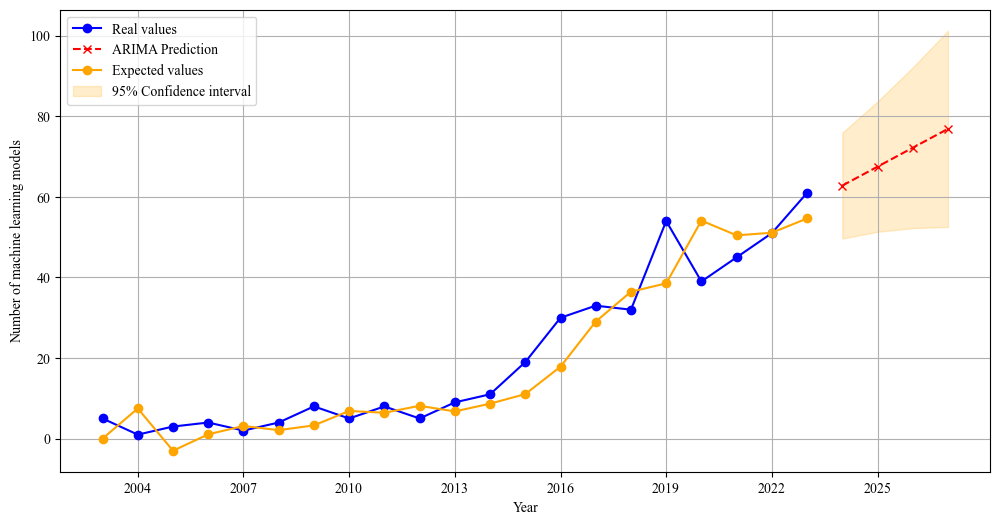

In [39]:
xticks_labels = df2.index.tolist()
xticks_labels.extend(future_dates)
xticks_filtered = [year for year in xticks_labels if year % 3 == 0]

predicted=sarima.fit().predict();predicted

plt.figure(figsize=(12, 6))
plt.plot(df2['ml_models'], marker='o', color='blue', label='Real values')
plt.plot(forecast_index, forecast.predicted_mean, marker='x', linestyle='--', color='red', label='ARIMA Prediction')
plt.plot(predicted, marker='o', color='orange', label='Expected values')
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1],
                 color='orange', alpha=0.2, label='95% Confidence interval')

plt.xlabel("Year")
plt.ylabel('Number of machine learning models')
plt.xticks(xticks_filtered)
plt.legend()
plt.grid(True)
plt.show()

In [40]:
mse_ar = mean_squared_error(df2['ml_models'], predicted)
rmse_ar = np.sqrt(mse_ar)
mae_ar = mean_absolute_error(df2['ml_models'], predicted)
rsquare_ar = r2_score(df2['ml_models'], predicted)
mape_ar = np.mean(np.abs((df2['ml_models'] - predicted)) / df2['ml_models'])* 100

print(f"Mean Squared Error (MSE): {mse_ar}")
print(f"RMSE: {rmse_ar:.2f}")
print(f"Mean Absolute Error (MAE): {mae_ar}")
print(f'Determination:', rsquare_ar)
print(f"Mean Absolute Percentage Error (MAPE): {mape_ar}")

Mean Squared Error (MSE): 45.20503715576434
RMSE: 6.72
Mean Absolute Error (MAE): 5.2539987952624205
Determination: 0.8789944558617278
Mean Absolute Percentage Error (MAPE): 73.85710536174798


The model is well suited for the data. The expected values are very close to the actual values for most of the series. According to the prediction, the number of relevant ML models will continue to grow in the United States. The expected growth rate will be similar to the development observed since 2019.

In [41]:
shapiro_stat, shapiro_p = shapiro(residuals)
print(f"Shapiro–Wilk statistic: = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

Shapiro–Wilk statistic: = 0.9758, p-value = 0.8552


In [42]:
arch_test = het_arch(residuals)
print(f"ARCH test p-value: {arch_test[1]:.4f}")

ARCH test p-value: 0.0386


The residuals show a normal distribution. Due to the heteroscedasticity of residuals demonstrated by the ARCH test, their values were additionally assessed.

Text(0, 0.5, 'ARIMA residuals values')

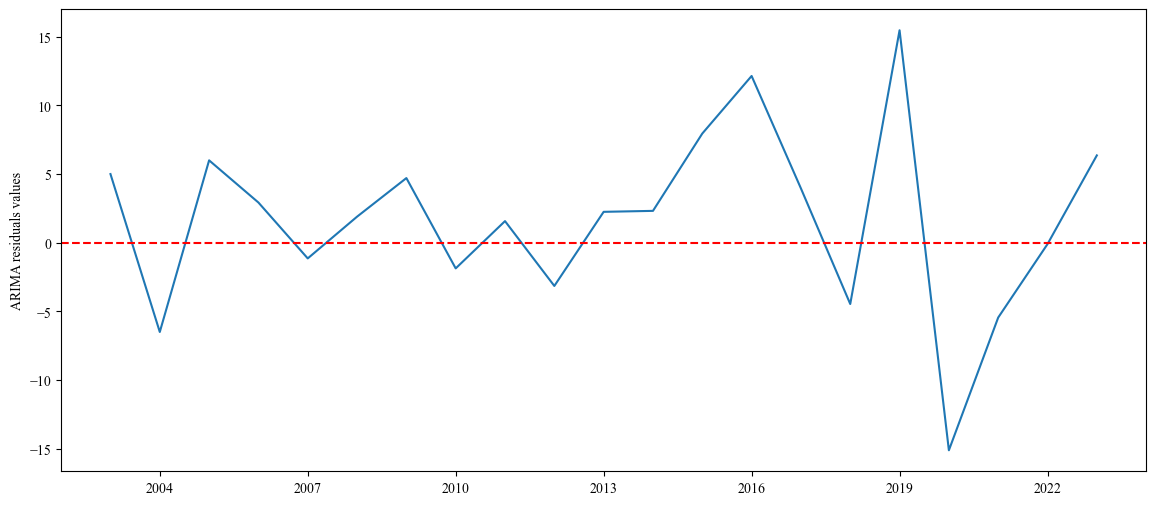

In [43]:
xticks_labels = df2.index.tolist()
xticks_filtered2 = [year for year in xticks_labels if year % 3 == 0]
plt.figure(figsize=(14, 6))
plt.plot(residuals)
plt.xticks(xticks_filtered2)
plt.axhline(0, color="red", linestyle="--")
plt.ylabel("ARIMA residuals values")

The ARIMA residuals plot indicates a possible change in the variance structure over time, especially after 2015. Therefore confidence intervals used for prediction are not representative of possible future data volatility.

### Dumped Holt model forecast on training dataset

In [44]:
future_years = test_years.values

holt_damped_model2 = ExponentialSmoothing(train, trend='add', damped_trend=True, seasonal=None).fit()
fitted_holt_damped = holt_damped_model2.fittedvalues
holt_damped_forecast2 = holt_damped_model2.forecast(4)

In [45]:
fitted_holt_damped

year
2003    3.10513471
2004    4.31170904
2005    1.78062692
2006    2.03008422
2007    3.24674124
2008    2.38244002
2009    3.51640894
2010    7.46629409
2011    6.97906631
2012    8.64829382
2013    6.76699735
2014    8.67536349
2015   11.29359876
2016   18.99144662
2017   31.58709266
2018   39.41053948
2019   40.35226640
dtype: float64

In [46]:
# Variance of residuals as a basis for standard error
residuals = train - fitted_holt_damped
res_var = np.var(residuals)
se = np.sqrt(res_var)

z = 1.96
ci_upper = holt_damped_forecast2 + z * se
ci_lower = holt_damped_forecast2 - z * se

In [47]:
forecast_steps = 4
z = 1.96
se_steps = [np.sqrt(res_var * h) for h in range(1, forecast_steps + 1)]
lower_bound = holt_damped_forecast2 - z * np.array(se_steps)
upper_bound = holt_damped_forecast2 + z * np.array(se_steps)

In [48]:
print("Damping parameter (phi):", holt_damped_model2.params['damping_trend'])

Damping parameter (phi): 0.995


The parameter responsible for damping reached a value close to one, which means that it won't have significant impact on the reduction of the predicted values.

(0.0, 100.0)

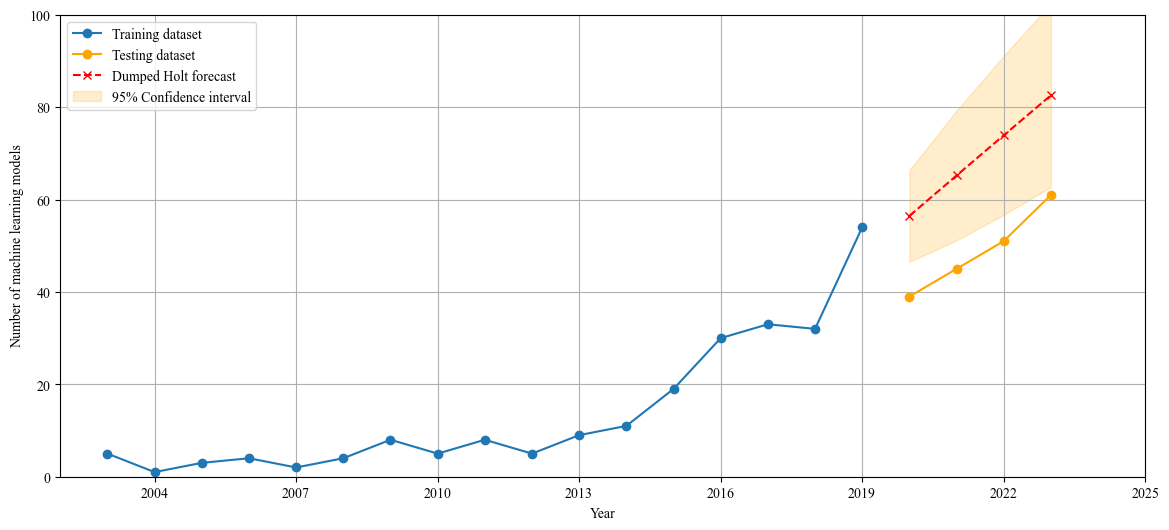

In [49]:
plt.figure(figsize=(14, 6))

plt.plot(train_years, train, label='Training dataset', marker='o')

plt.plot(test_years, test, label='Testing dataset', color='orange', marker='o')

plt.plot(future_years, holt_damped_forecast2,label='Dumped Holt forecast', marker='x', linestyle='--', color='red')

plt.fill_between(future_years, lower_bound, upper_bound, label='95% Confidence interval', color='orange', alpha=0.2)

plt.xlabel("Year")
plt.ylabel("Number of machine learning models")
plt.legend()
plt.xticks(xticks_filtered)
plt.grid(True)
plt.ylim(0, 100)

The forecast is similar to that made with the ARIMA model. The values increase slightly slower, with the average growth rate in 2020-2023 being 13.5%, and for the ARIMA model it was one percentage point higher.

In [50]:
holt_damped_forecast2

17   56.45511767
18   65.19994303
19   73.90104427
20   82.55864000
dtype: float64

In [51]:
forecast_mean

17   57.05566394
18   66.59393500
19   76.13220605
20   85.67047711
Name: predicted_mean, dtype: float64

### Dumped Holt forecast on full dataset

In [52]:
holt_damped_model3 = ExponentialSmoothing(df2['ml_models'], trend='add', damped_trend=True, seasonal=None).fit()
fitted_holt_damped3 = holt_damped_model3.fittedvalues
holt_damped_forecast3 = holt_damped_model3.forecast(4)

In [53]:
holt_damped_forecast3

21   62.57082150
22   67.12611461
23   71.65863125
24   76.16848531
dtype: float64

In [54]:
residuals = df2['ml_models'] - fitted_holt_damped3
res_var = np.var(residuals)
se = np.sqrt(res_var)

In [55]:
forecast_steps = 4
z = 1.96
se_steps = [np.sqrt(res_var * h) for h in range(1, forecast_steps + 1)]
lower_bound = holt_damped_forecast3 - z * np.array(se_steps)
upper_bound = holt_damped_forecast3 + z * np.array(se_steps)

In [56]:
last_year = df2.index.max()

forecast_index = pd.Index([last_year + i for i in range(1, 5)])

forecast_series = pd.Series(holt_damped_forecast3.values, index=forecast_index)

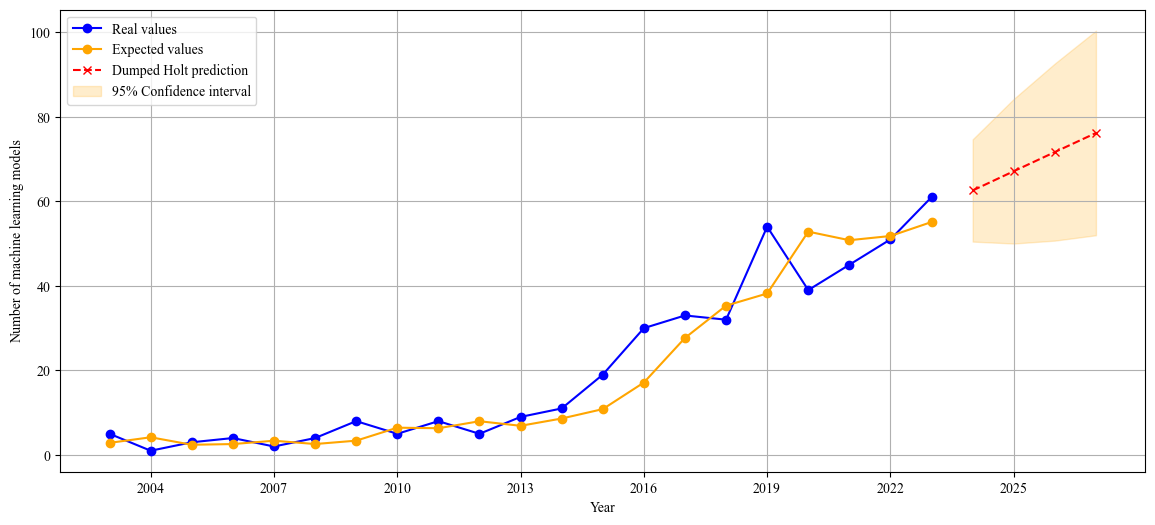

In [57]:
plt.figure(figsize=(14, 6))
plt.plot(df2['ml_models'], marker='o', color='blue', label='Real values')
plt.plot(fitted_holt_damped3, marker='o', color='orange', label='Expected values')
plt.plot(forecast_index, holt_damped_forecast3, label='Dumped Holt prediction', marker='x', linestyle='--', color='red')
plt.fill_between(forecast_index, lower_bound, upper_bound, label='95% Confidence interval', color='orange', alpha=0.2)
plt.xlabel("Year")
plt.ylabel('Number of machine learning models')
plt.xticks(xticks_filtered)
plt.legend()
plt.grid(True)
plt.show()

In [58]:
print("Damping parameter (phi):", holt_damped_model3.params['damping_trend'])

Damping parameter (phi): 0.9949999997370674


The forecast again differs slightly from that made using the ARIMA model. Damping had a negligible effect on the forecast suppression, as the parameter reached a value close to one.

In [59]:
mse_hw = mean_squared_error(df2['ml_models'], fitted_holt_damped3)
rmse_hw = np.sqrt(mse_hw)
mae_hw = mean_absolute_error(df2['ml_models'], fitted_holt_damped3)
rsquare_hw = r2_score(df2['ml_models'], fitted_holt_damped3)
mape_hw = np.mean(np.abs((df2['ml_models'] - fitted_holt_damped3)) / df2['ml_models'])* 100

In [60]:
results = pd.DataFrame({
    'Model': ['Holt', 'AR'],
    'MSE': [mse_hw, mse_ar],
    'RMSE': [rmse_hw, rmse_ar],
    'MAE': [mae_hw, mae_ar],
    'R²': [rsquare_hw, rsquare_ar]
})

results = results.apply(pd.to_numeric, errors='ignore').round(3)

display(results.style.format({
    "MSE": "{:.3f}",
    "RMSE": "{:.3f}",
    "MAE": "{:.3f}",
    "R²": "{:.3f}"
})
 .hide(axis="index")   
)


Model,MSE,RMSE,MAE,R²
Holt,40.366,6.353,4.625,0.892
AR,45.205,6.723,5.254,0.879


The Holt model fit the data to a similar degree as the ARIMA model. The coefficient of determination achieved the same high value. The largest difference in values was observed for the mean absolute percentage error; however, this measure is not fully reliable due to the low time series values. 

In [61]:
shapiro_stat, shapiro_p = shapiro(residuals)
print(f"Test Shapiro–Wilka: statystyka = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

Test Shapiro–Wilka: statystyka = 0.9547, p-value = 0.4165


In [62]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(residuals)
print(f"ARCH test p-value: {arch_test[1]:.4f}")

ARCH test p-value: 0.1009


The p-values for Holt's model residuals were above 0.1 for both tests. Using the standard significance level of 0.05, the model residuals were found to be normal and exhibited relatively constant variance.

### Summary for USA prediction

For the United States, two forecasts were ultimately prepared based on two different models tailored to the nature of the time series. The observed lack of seasonality, high variability, and low autocorrelation between lags prevented the detection of patterns in the data. For such a short time series, these properties were sufficient to prevent the training of models such as Gradient Boosting or Prophet.